In [1]:
import keras

Using TensorFlow backend.


In [2]:
def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False

In [3]:
classification_model = keras.models.load_model('/Users/arjasethan/Downloads/hashing_Vgg19.49.hdf5')

In [4]:
classification_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [5]:
hashing_model = keras.models.Model(inputs=classification_model.input, outputs=[classification_model.layers[-2].output, classification_model.layers[-4].output])

In [6]:
hashing_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [7]:
base_data_dir= '/Users/arjasethan/DataScience/DeepLearning/DL4j/input/NWPU-RESISC45/NWPU-RESISC45/'

In [8]:
import numpy as np
import cv2
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
x = cv2.imread(base_data_dir + 'airplane/airplane_001.jpg')

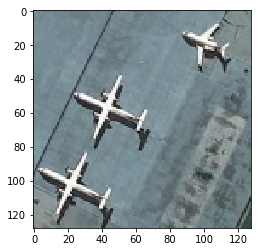

In [10]:
plt.imshow(cv2.resize(x, (128,128))/255.)

In [11]:
def generator(base_data_dir, batch_size, image_size):
    batch_count = 1
    class_labels = os.listdir(base_data_dir)
    image_paths = [base_data_dir + label + '/' + file for label in class_labels 
               if '.' not in label 
               for file in os.listdir(base_data_dir + label)
               if file.endswith('.jpg')
              ]
    num_iters = len(image_paths) // batch_size
    if num_iters == len(image_paths) / batch_size:
        num_iters = num_iters -1
    while True:
        batch= []
        batch_paths = image_paths[(batch_count-1)*batch_size: batch_count*batch_size]
        for img_path in batch_paths:
            img= cv2.imread(img_path)
            batch.append(cv2.resize(img,image_size).astype(np.float32))
        if batch_count <= num_iters:
            batch_count +=1
        else:
            batch_count = 1
        yield np.stack(batch,0)/255, batch_paths, batch_count

In [12]:
data_gen = generator(base_data_dir, 32, (128,128))

In [13]:
a = 0
images =[]
predictions = []
while a !=1:
    input_data, paths, a = next(data_gen)
    batch_output = hashing_model.predict(input_data)
    predictions = predictions + list(zip(batch_output[0], batch_output[1]))
    images = images + paths
    print(a)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [14]:
index ={}
for image,pred in zip(images,predictions):
    index[image] = pred

In [15]:
import scipy

In [16]:
class searcher:
    def __init__(self, dic):
        self.dic = dic
    def search(self, query_image, num_top_matches= 5, num_candidates=500):
        result = {}
        query_binary, query_encoding = self.dic[query_image]
        for key in self.dic:
            image_binary, _ = self.dic[key]
            image_binary = np.round(image_binary)
            result[key] = scipy.spatial.distance.hamming(query_binary, image_binary)
        candidates = dict(sorted(result.items(), key= lambda kv: kv[1])[:num_candidates])
        result = {}
        for key in candidates:
            _, image_encoding = self.dic[key]
            result[key] = scipy.spatial.distance.euclidean(query_encoding, image_encoding)
        return(dict(sorted(result.items(), key= lambda kv: kv[1])[:num_top_matches]))
        
    def _get_image(self, path):
        img= cv2.imread(path)
        name = path.split('/')[-1]
        return img/255, name
    
    def plot_top_matches(self, query_image, num_top_matches= 5, num_candidates=500):
        matches = self.search(query_image, num_top_matches, num_candidates)
        idx = 1
        plt.figure(figsize=[50,50])
        for key in matches:
            image_data, name = self._get_image(key)
            plt.subplot(num_top_matches, 1, idx)
            plt.title('{}:{:.2f}'.format(name, matches[key]))
            plt.imshow(image_data)
            idx +=1

In [17]:
search = searcher(index)

In [18]:
images[700]

'/Users/arjasethan/DataScience/DeepLearning/DL4j/input/NWPU-RESISC45/NWPU-RESISC45/railway_station/railway_station_164.jpg'

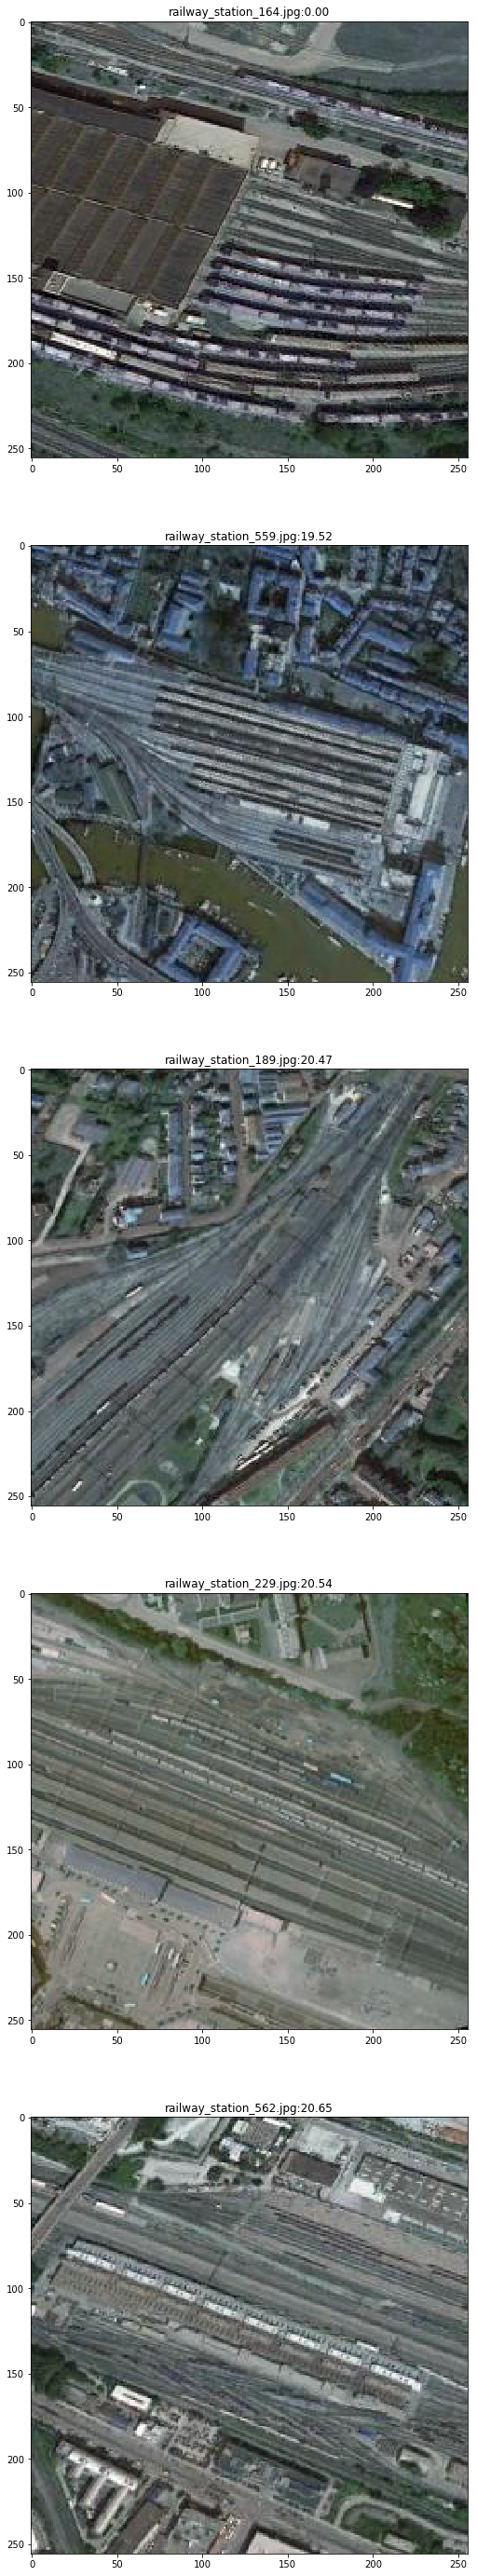

In [19]:
search.plot_top_matches(images[700], 5, 100)

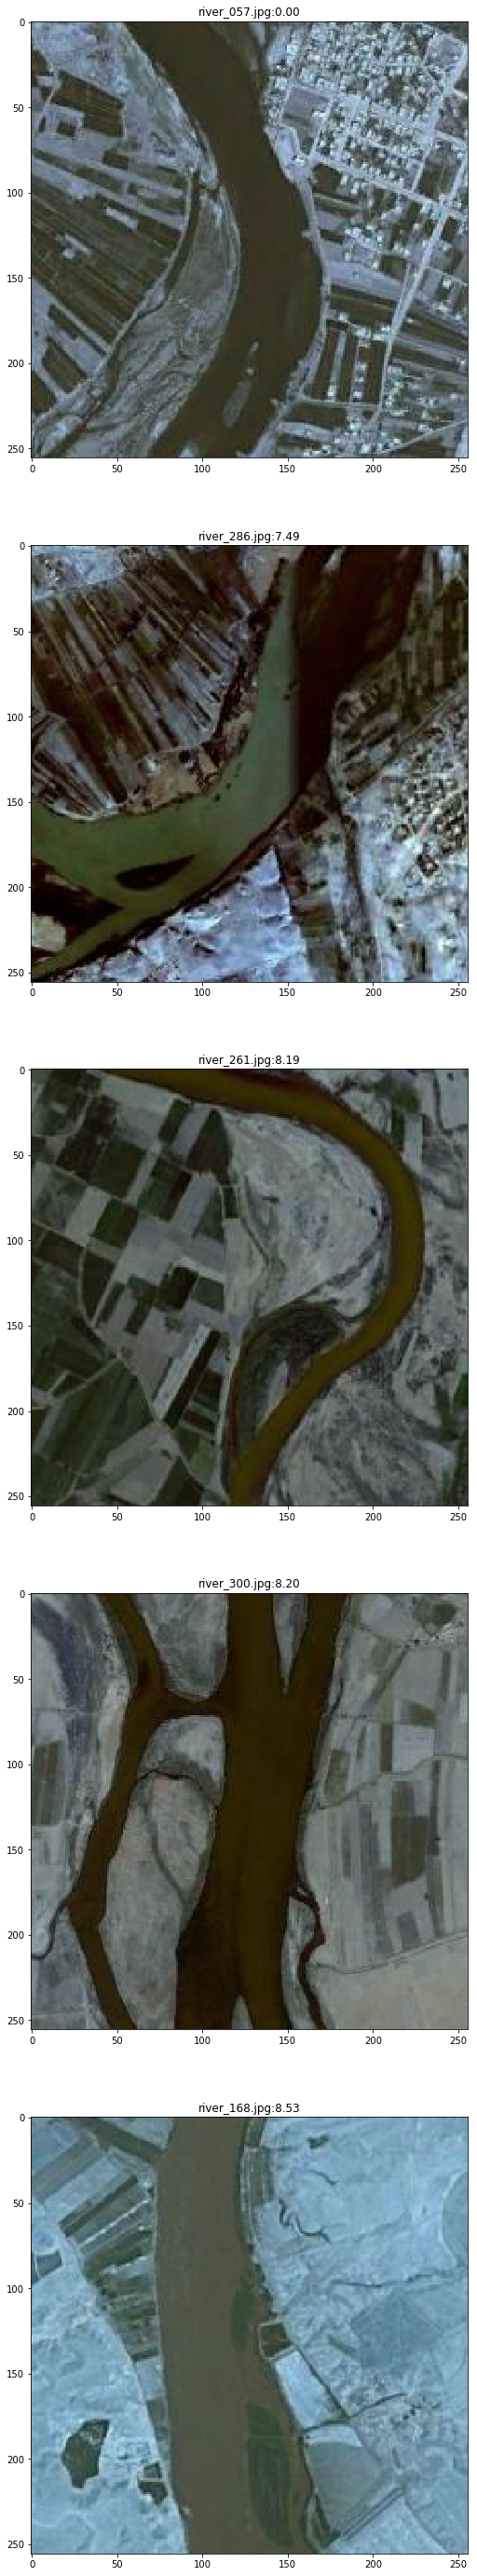

In [30]:
search.plot_top_matches(images[3000], 5, 10000)

In [24]:
images[1500]

'/Users/arjasethan/DataScience/DeepLearning/DL4j/input/NWPU-RESISC45/NWPU-RESISC45/tennis_court/tennis_court_345.jpg'

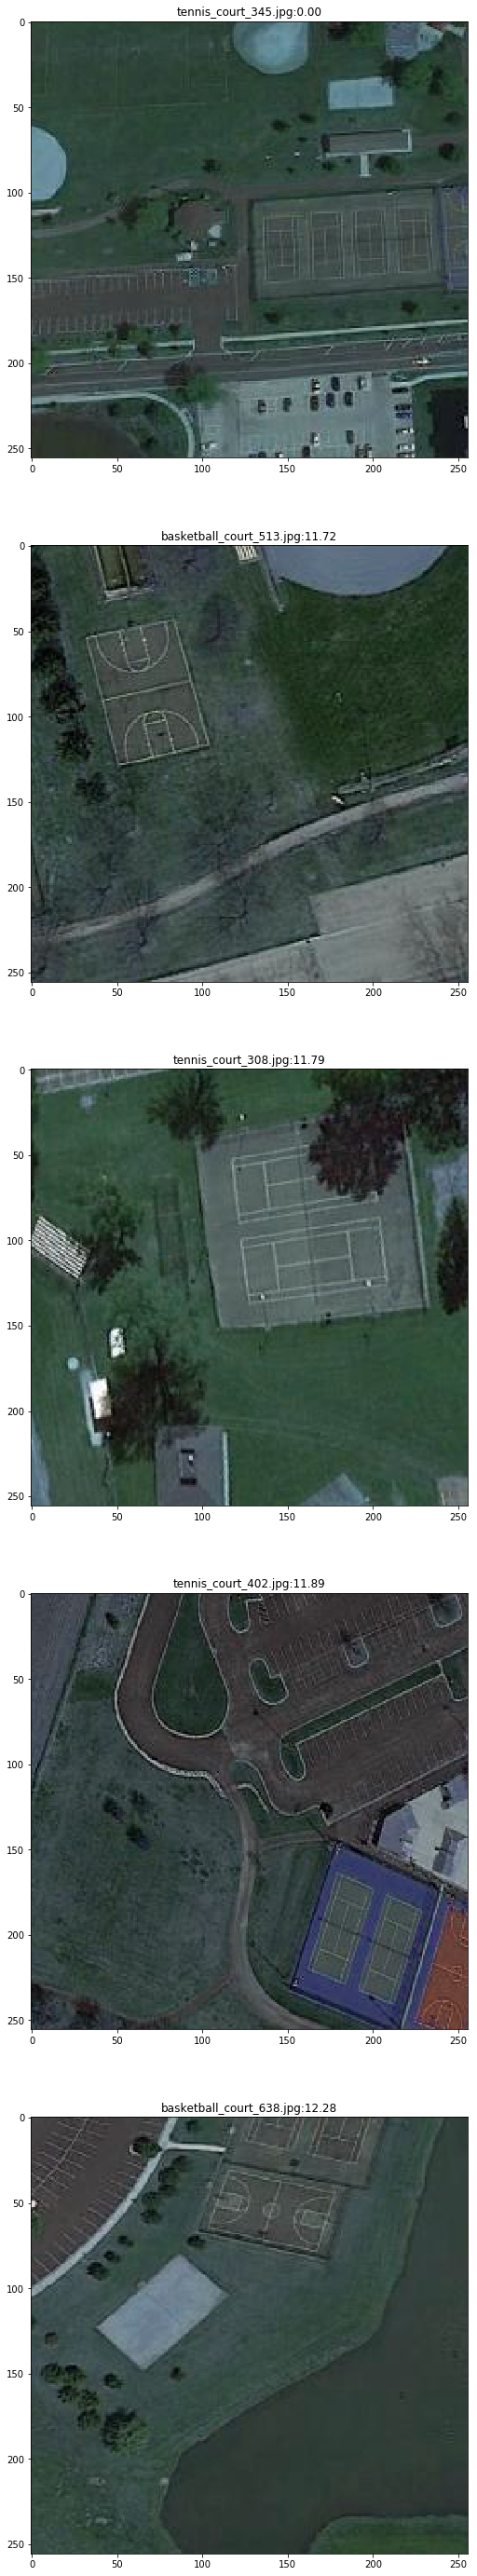

In [31]:
search.plot_top_matches(images[1500], 5, 3000)

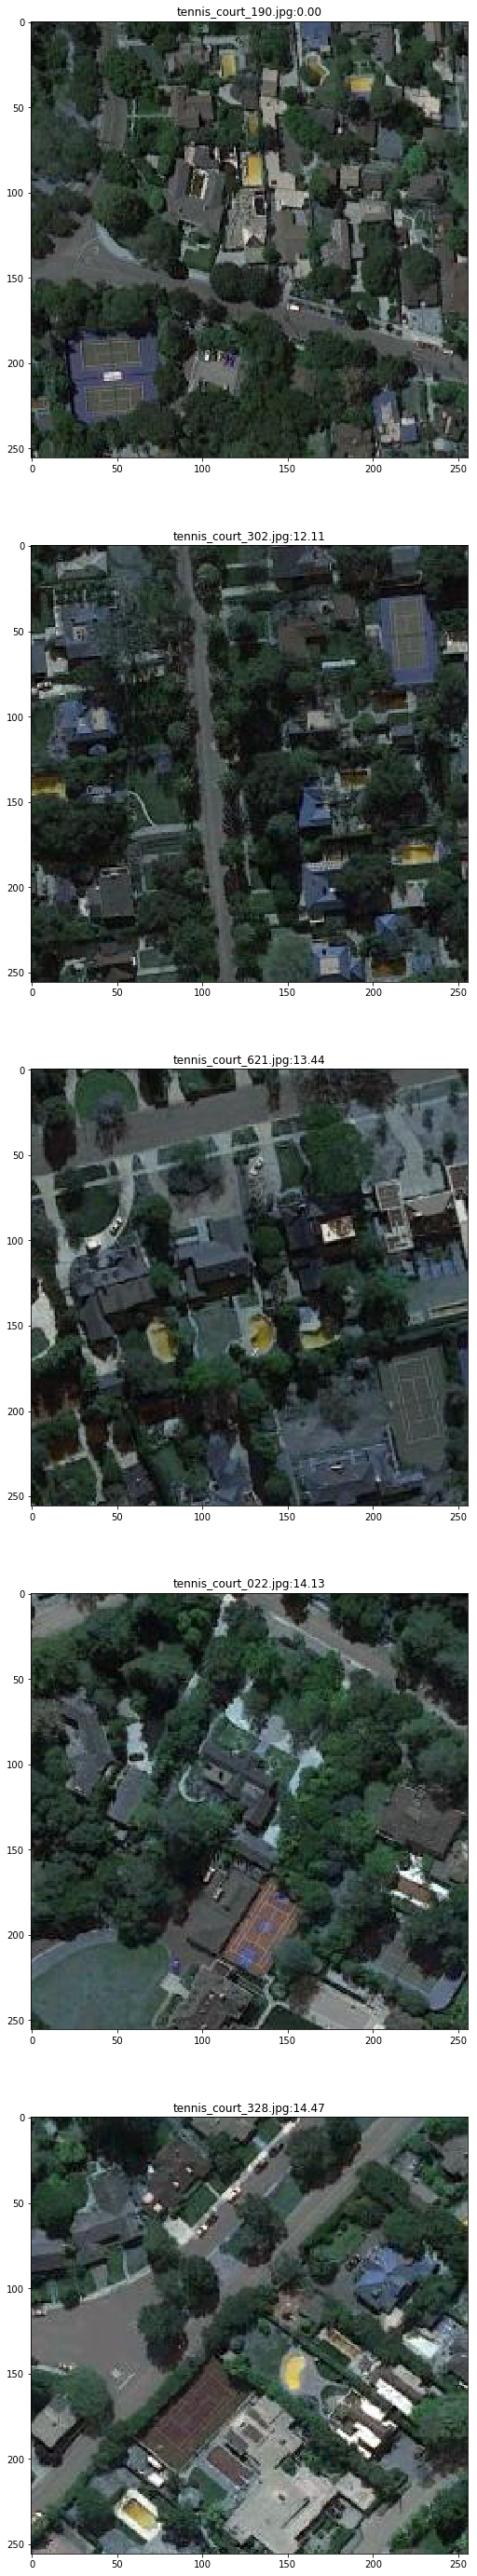

In [32]:
search.plot_top_matches(images[1501], 5, 3000)